**1. Data cleaning:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import warnings

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
# Reading the dataset
df = pd.read_csv('/content/clean_kaggle_data_2020.csv')
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...

In [ ]:
#Dropping the first row from the dataset as its just the questions for the responses so its not required 
df.drop(0, axis=0,inplace=True)

In [ ]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

84.34079941977724

In [ ]:
warnings.filterwarnings("ignore")
# First lets remove all columns with at least one missing value
columns_with_na_dropped = df.dropna(axis=1)
columns_with_na_dropped.drop(columns=['Time from Start to Finish (seconds)'],inplace=True)
columns_with_na_dropped
# Let's display all the columns that are still present without any na values
columns_with_na_dropped.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q20', 'Q21', 'Q22', 'Q24',
       'Q24_Encoded', 'Q24_buckets'],
      dtype='object')

In [ ]:
#Now lets work on all the columns in the droped dataset starting with Q3 
#Since Q3 is a country column where there is no ordinal relationship its better to do One Hot Encoding for it, by creating dummy variables 
df_dum_countries = pd.get_dummies(df.Q3)
df_dum_countries
#Similarly the same is done for the columns Q2,Q5,Q22
df_dum_gend = pd.get_dummies(df.Q2)
df_dum_role = pd.get_dummies(df.Q5)
df_dum_have_ml = pd.get_dummies(df.Q22)

In [ ]:
warnings.filterwarnings("ignore")
# For Q1 as it represents the age range the average age is taken instead
Q1_age_encode = {'18-21': 0,'22-24': 1,'25-29': 2,'30-34': 3,'35-39': 4,'40-44': 5,'45-49': 6,'50-54': 7,'55-59': 8,'60-69': 9,'70+': 10}
columns_with_na_dropped['Q1'] = columns_with_na_dropped.Q1.map(Q1_age_encode)

#For Q4 degrees as it has ordinal relationship we can doe label encoding for it
Q4_education_encode = {   
    'I prefer not to answer': 0,
    'No formal education past high school': 1,
    'Some college/university study without earning a bachelor’s degree': 2,
    'Professional degree': 3,
    'Bachelor’s degree': 4,
    'Master’s degree': 5,
    'Doctoral degree': 6,
    }
columns_with_na_dropped['Q4'] = columns_with_na_dropped.Q4.map(Q4_education_encode)

# Similarly for Q6,Q20,Q21 ordinal relationship exists so label encoding is done for them
Q6_exp_encode = {'3-5 years':3,
                '5-10 years':4, 
                 '1-2 years':2,   
                 '10-20 years':5,    
                 '< 1 years':1,                    
                 '20+ years':6,
                 'I have never written code':0}

columns_with_na_dropped['Q6'] = columns_with_na_dropped.Q6.map(Q6_exp_encode)

#Q20 Employee numbers in a company
Q20_emp_encode = {'0-49 employees':0,
'10,000 or more employees':4,
'1000-9,999 employees':3,
'50-249 employees':1,
'250-999 employees':2 }

columns_with_na_dropped['Q20'] = columns_with_na_dropped.Q20.map(Q20_emp_encode)

#Q21 Individuals who do data analytics in company
Q21_data_ind_encode = {'1-2':1,      
'20+': 6,
'0':0,
'3-4':2,
'5-9':3,
'10-14':4,
'15-19':5 }

columns_with_na_dropped['Q21'] = columns_with_na_dropped.Q21.map(Q21_data_ind_encode)

# Concatinating all the dummy datasets together to crate a final dataset 
final_df = pd.concat([columns_with_na_dropped,df_dum_gend,df_dum_countries,df_dum_role,df_dum_have_ml], axis='columns')
# Removing all the original columns from the dataset
final_df.drop(columns=['Q2','Q3','Q5','Q22'],inplace=True)


In [ ]:
"""" Droping all the columns that contains 'OTHER' in their names as these columns are very small in percent 
  and they don't provide much info as the people just selected other and didn't provide anything so they are all droped """
other_col = []
for col in df.columns:
    if "OTHER" in col:
        other_col.append(col)
df3 = df.drop(other_col, axis=1) #droping all the columns with that name

# Selecting all the columns that are part of the multiple choice questions indicated by the 'Part' in the column name
mcq_col = []
for col in df.columns:
    if "Part" in col:
        mcq_col.append(col)  #appending all the column names that have 'part' in their names

# Droping all the mcq columns from the dataframe
df3 = df.drop(mcq_col, axis=1)

# Here one hot encoding is done to all the mcq columns by converting all the non string cells to '0' and the string cells are changed to '1'
for col in mcq_col:
    temp = []
    temp.append(int(0))
    for row in range(df.shape[0]):  
        is_str = isinstance(df[col][row+1], str)
        if is_str == True:  #if the cell contains a string '1'else '0'
            temp.append(int(1))
        else:
            temp.append(int(0))           
    df3[col] = pd.DataFrame(temp, columns=[col]) #This is then put back into the dataframe df3

#Droping all the columns that is already pre-processed from the dataframe  
df3.drop(columns=['Q1','Q2','Q3','Q4','Q5','Q6','Time from Start to Finish (seconds)','Q20','Q21','Q24','Q22','Q24_buckets','Q24_Encoded'],inplace=True)
# Concatinating this dataframe df3 with the previous final_df dataframe
final_df = pd.concat([final_df,df3],axis='columns')


In [ ]:
 """ In order to see the last few columns that needs to be pre-processed. 
    We are going to remove all the columns that have already been processed/worked on """
warnings.filterwarnings("ignore")

#Droping the 'part' column
non_mcq_col = []
for col in df.columns:
    if "Part" not in col:
        non_mcq_col.append(col)

df_mod = df[non_mcq_col]
df_mod.drop(columns=['Q1','Q2','Q3','Q4','Q5','Q6','Time from Start to Finish (seconds)','Q20','Q21','Q24','Q22','Q24_buckets','Q24_Encoded'],inplace=True)
#Droping the 'other' column
other_col = []
for col in df.columns:
    if "OTHER" in col:
        other_col.append(col)
df_mod = df_mod.drop(other_col, axis=1)

# Displaying the remaining 8 columns that needs to be pre-processed
df_mod

,Q8,Q11,Q13,Q15,Q25,Q30,Q32,Q38
1,Python,A personal computer or laptop,2-5 times,1-2 years,"$100,000 or more ($USD)",PostgresSQL,Microsoft Power BI,"Business intelligence software (Salesforce, Ta..."
2,R,A personal computer or laptop,Never,I do not use machine learning methods,$0 ($USD),NaN,NaN,"Basic statistical software (Microsoft Excel, G..."
3,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,3-4 years,"$10,000-$99,999",MySQL,NaN,"Local development environments (RStudio, Jupyt..."
4,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,2-3 years,"$10,000-$99,999",Microsoft Azure Data Lake Storage,NaN,"Cloud-based data software & APIs (AWS, GCP, Az..."
5,R,A personal computer or laptop,Never,Under 1 year,$1-$99,NaN,NaN,"Local development environments (RStudio, Jupyt..."
...,...,...,...,...,...,...,...,...
10725,C++,A personal computer or laptop,Never,1-2 years,$0 ($USD),NaN,NaN,"Basic statistical software (Microsoft Excel, G..."
10726,Python,A personal computer or laptop,Never,I do not use machine learning methods,$0 ($USD),Microsoft SQL Server,Microsoft Power BI,"Local development environments (RStudio, Jupyt..."
10727,Python,A personal computer or laptop,Never,I do not use machine learning methods,$0 ($USD),NaN,NaN,NaN
10728,Python,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,1-2 years,$0 ($USD),NaN,NaN,"Local development environments (RStudio, Jupyt..."


In [ ]:
# For Q8 replacing all nan values with 'None' categories
df_mod['Q8'].replace(np.nan, 'None',inplace=True)
# Performing one hot encoding on the column
df_dum_lang_rec = pd.get_dummies(df_mod.Q8)
#Droping the 'other' category
df_dum_lang_rec.drop(columns=['Other'],inplace=True)
# Droping the original column from the dataset
final_df.drop(columns=['Q8'],inplace=True)
#Concatinating it to the final_df dataframe
final_df = pd.concat([final_df,df_dum_lang_rec],axis='columns')

#Similarly for Q11 the same steps are done
df_mod['Q11'].replace(np.nan, 'None',inplace=True)
df_dum_plat = pd.get_dummies(df_mod.Q11)
df_dum_plat.drop(columns=['Other'],inplace=True)
final_df.drop(columns=['Q11'],inplace=True)
final_df = pd.concat([final_df,df_dum_plat],axis='columns')
# For Q13 same as Q11 one hot encoding is done
df_mod['Q13'].replace(np.nan, 'Never',inplace=True)
df_dum_tpu_use = pd.get_dummies(df_mod.Q13)
final_df.drop(columns=['Q13'],inplace=True)
final_df = pd.concat([final_df,df_dum_tpu_use],axis='columns')

# FOR Q15 replacing nan values with 'I do not use machine learning methods'
df_mod['Q15'].replace(np.nan, 'I do not use machine learning methods',inplace=True)
# Label encoding is done as the data has ordinal relationship
Q15_ml_exp_encode = {'Under 1 year':1,
                     '1-2 years':2,
                     'I do not use machine learning methods':0,
                     np.nan:0,
                     '2-3 years':3,
                     '3-4 years':4, 
                     '5-10 years':5,
                     '4-5 years':6,
                     '10-20 years':7,
                     '20 or more years':8 }

final_df['Q15'] = final_df.Q15.map(Q15_ml_exp_encode)  

#Similarly Q25 label encoding is done
df_mod['Q25'].value_counts(dropna=False)
df_mod['Q25'].replace(np.nan, '$0 ($USD)',inplace=True)
Q25_money_ml = {'$0 ($USD)':0,
'$1000-$9,999':3,
'$100-$999':2,
'$1-$99':1,
'$10,000-$99,999':4,
'$100,000 or more ($USD)':5,
np.nan:0}

final_df['Q25'] = final_df.Q25.map(Q25_money_ml)  

#Q38 one hot encoding is done after replacing the nan values
df_mod['Q38'].value_counts(dropna=False)
df_mod['Q38'].replace(np.nan, 'Other',inplace=True)
df_dum_tool_use = pd.get_dummies(df_mod.Q38)
df_dum_tool_use.drop(columns=['Other'],inplace=True)
final_df.drop(columns=['Q38'],inplace=True)
final_df = pd.concat([final_df,df_dum_tool_use],axis='columns')

#Similarly Q30 and Q32  one hot encoding is done after replacing the nan values
df_mod['Q30'].value_counts(dropna=False)
df_mod['Q30'].replace(np.nan, 'Other',inplace=True)
df_dum_int_tool = pd.get_dummies(df_mod.Q30)
df_dum_int_tool.drop(columns=['Other'],inplace=True)
final_df.drop(columns=['Q30'],inplace=True)
final_df = pd.concat([final_df,df_dum_int_tool],axis='columns')
#Q32
df_mod['Q32'].value_counts(dropna=False)
df_mod['Q32'].replace(np.nan, 'Other',inplace=True)
df_dum_tools = pd.get_dummies(df_mod.Q32)
df_dum_tools.drop(columns=['Other'],inplace=True)
final_df.drop(columns=['Q32'],inplace=True)
final_df = pd.concat([final_df,df_dum_tools],axis='columns')

#Droping all 'OTHER' columns
other_col = []
for col in df.columns:
    if "OTHER" in col:
        other_col.append(col)
final_df = final_df.drop(other_col, axis=1)

In [ ]:
# Displaying the final processed datafram
final_df

,Q1,Q4,Q6,Q20,Q21,Q24,Q24_Encoded,Q24_buckets,Man,Nonbinary,Prefer not to say,Prefer to self-describe,Woman,Argentina,Australia,Bangladesh,Belarus,Belgium,Brazil,Canada,Chile,China,Colombia,Egypt,France,Germany,Ghana,Greece,India,Indonesia,"Iran, Islamic Republic of...",Ireland,Israel,Italy,Japan,Kenya,Malaysia,Mexico,Morocco,Nepal,...,None,2-5 times,6-25 times,More than 25 times,Never,Once,"Advanced statistical software (SPSS, SAS, etc.)","Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Local development environments (RStudio, JupyterLab, etc.)",Amazon Athena,Amazon DynamoDB,Amazon Redshift,Google Cloud BigQuery,Google Cloud Firestore,Google Cloud SQL,IBM Db2,Microsoft Access,Microsoft Azure Data Lake Storage,Microsoft SQL Server,MongoDB,MySQL,Oracle Database,PostgresSQL,SQLite,Snowflake,Alteryx,Amazon QuickSight,Domo,Einstein Analytics,Google Data Studio,Looker,Microsoft Power BI,Qlik,SAP Analytics Cloud,Salesforce,Sisense,TIBCO Spotfire,Tableau
1,32.0,5,4,4,6,"100,000-124,999",10.0,"100,000-124,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,36.5,4,5,3,0,"15,000-19,999",1.0,"10,000-19,999",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,32.0,5,4,2,3,"125,000-149,999",11.0,"125,000-149,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,36.5,6,4,3,6,"70,000-79,999",7.0,"70,000-79,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,36.5,6,2,0,1,"30,000-39,999",3.0,"30,000-39,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,36.5,0,2,0,3,"2,000-2,999",0.0,"0-9,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10726,36.5,4,5,2,0,"15,000-19,999",1.0,"10,000-19,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10727,32.0,5,1,0,0,$0-999,0.0,"0-9,999",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10728,23.0,4,3,4,6,$0-999,0.0,"0-9,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**PART 2  Exploratory data analysis and feature selection:**


Text(0.5, 1.0, 'Average Age vs Yearly Compensation Bucket')

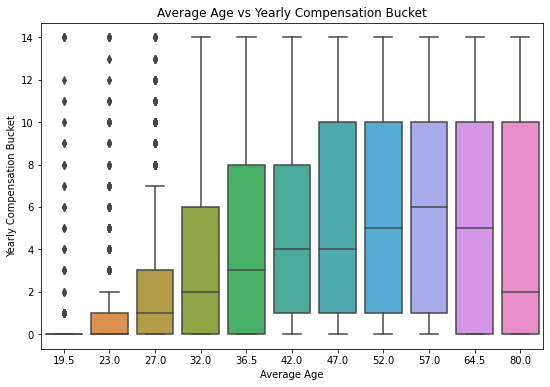

In [ ]:
#For exploratory data analysis 
# we can see the correlation between avg age and yearly compensation
plt.figure(figsize=(9,6))
sns.boxplot(x=final_df['Q1'],y=final_df['Q24_Encoded'],data=df)
plt.xticks(plt.xticks()[0], ('18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+'))
plt.xlabel('Age')
plt.ylabel('Yearly Compensation Bucket')
plt.title('Age vs Yearly Compensation Bucket')

Text(0.5, 1.0, 'Average Coding Experience vs Yearly Compensation Bucket')

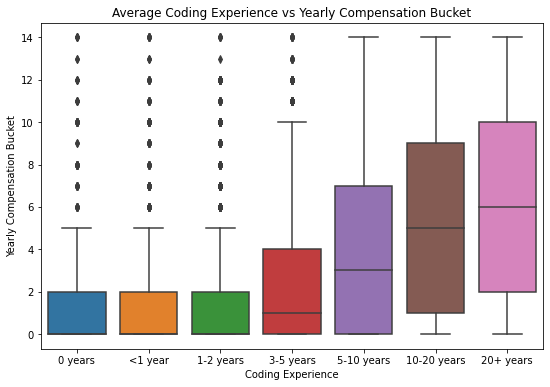

In [ ]:
# Yearly compensation based on coding experience
plt.figure(figsize=(9,6))
sns.boxplot(x=final_df['Q6'],y=final_df['Q24_Encoded'],data=final_df)
plt.xticks(plt.xticks()[0], ('0 years',
    '<1 year',
    '1-2 years',
    '3-5 years',
    '5-10 years',
    '10-20 years',
    '20+ years'))
plt.xlabel('Coding Experience')
plt.ylabel('Yearly Compensation Bucket')
plt.title('Average Coding Experience vs Yearly Compensation Bucket')

Text(0.5, 1.0, 'Size of Company vs Yearly Compensation Bucket')

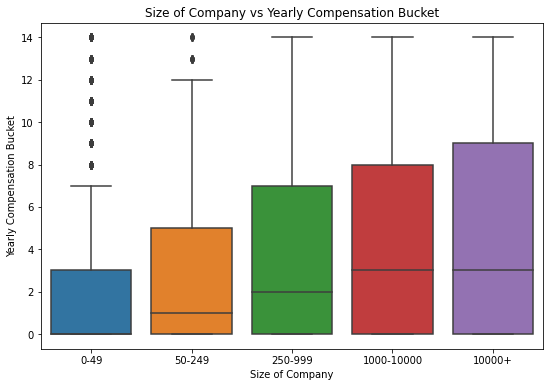

In [ ]:
# Size of company vs yearly compensation
plt.figure(figsize=(9,6))
sns.boxplot(x=final_df['Q20'],y=final_df['Q24_Encoded'],data=final_df)
plt.xticks(plt.xticks()[0], ('0-49',
    '50-249',
    '250-999',
    '1000-10000',
    '10000+'))
plt.xlabel('Size of Company')
plt.ylabel('Yearly Compensation Bucket')
plt.title('Size of Company vs Yearly Compensation Bucket')

Text(0.5, 1.0, 'Role in the Company vs Yearly Compensation Bucket')

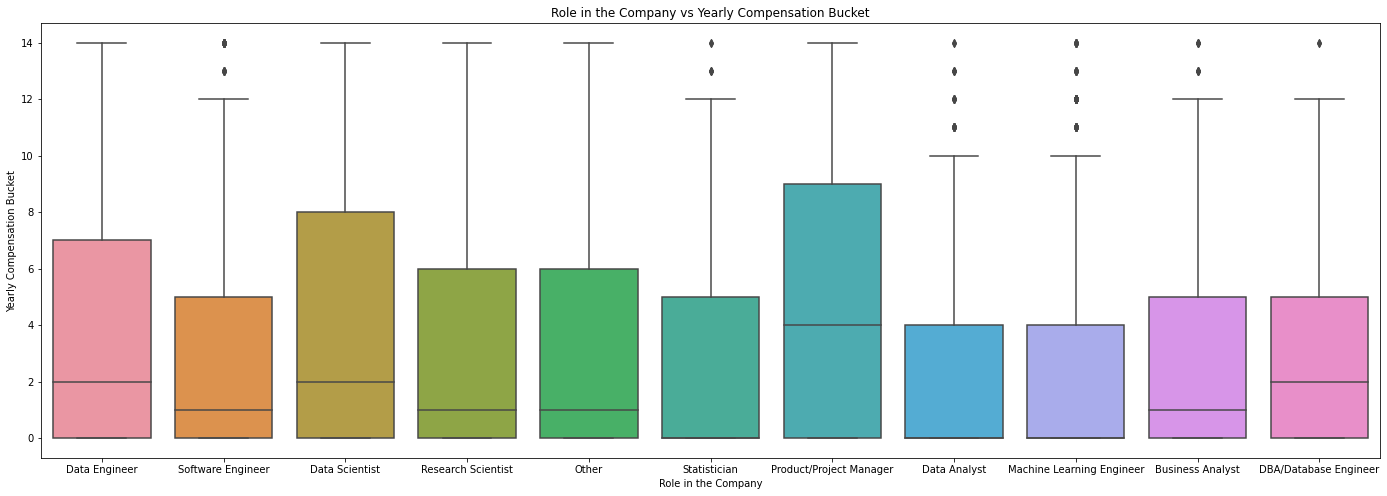

In [ ]:
#Role in a company vs yearly compensation
plt.figure(figsize=(24,8))
sns.boxplot(x=df['Q5'],y=df['Q24_Encoded'],data=df)
plt.xlabel('Role in the Company')
plt.ylabel('Yearly Compensation Bucket')
plt.title('Role in the Company vs Yearly Compensation Bucket')


Text(0.5, 1.0, 'Degree vs Yearly Compensation Bucket')

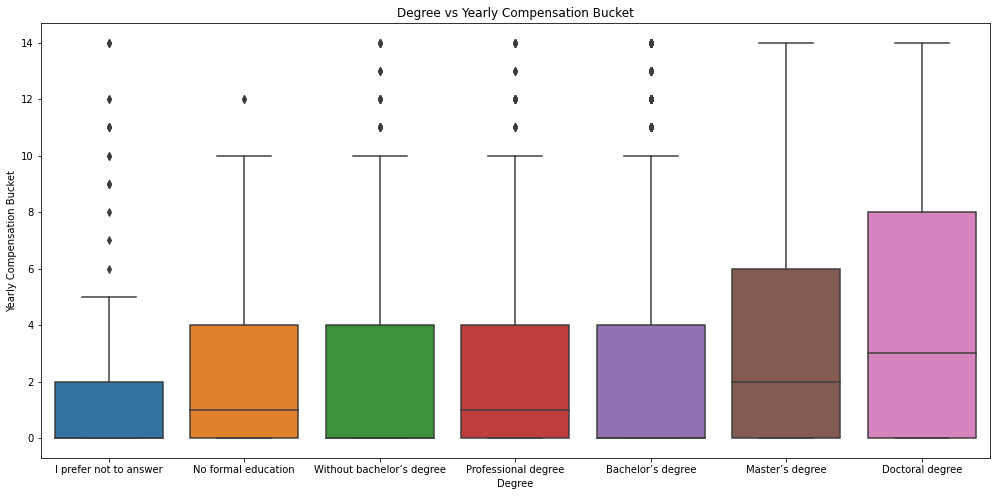

In [ ]:
# Degree vs Yearly compensation
plt.figure(figsize=(17,8))
sns.boxplot(x=final_df['Q4'],y=final_df['Q24_Encoded'],data=final_df)
plt.xticks(plt.xticks()[0], ('I prefer not to answer','No formal education','Without bachelor’s degree','Professional degree','Bachelor’s degree','Master’s degree','Doctoral degree'))
plt.xlabel('Degree')
plt.ylabel('Yearly Compensation Bucket')
plt.title('Degree vs Yearly Compensation Bucket')

In [ ]:
#Correlation for the entire dataset
final_df.corr()

,Q1,Q4,Q6,Q20,Q21,Q24_Encoded,Man,Nonbinary,Prefer not to say,Prefer to self-describe,Woman,Argentina,Australia,Bangladesh,Belarus,Belgium,Brazil,Canada,Chile,China,Colombia,Egypt,France,Germany,Ghana,Greece,India,Indonesia,"Iran, Islamic Republic of...",Ireland,Israel,Italy,Japan,Kenya,Malaysia,Mexico,Morocco,Nepal,Netherlands,Nigeria,...,None,2-5 times,6-25 times,More than 25 times,Never,Once,"Advanced statistical software (SPSS, SAS, etc.)","Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Local development environments (RStudio, JupyterLab, etc.)",Amazon Athena,Amazon DynamoDB,Amazon Redshift,Google Cloud BigQuery,Google Cloud Firestore,Google Cloud SQL,IBM Db2,Microsoft Access,Microsoft Azure Data Lake Storage,Microsoft SQL Server,MongoDB,MySQL,Oracle Database,PostgresSQL,SQLite,Snowflake,Alteryx,Amazon QuickSight,Domo,Einstein Analytics,Google Data Studio,Looker,Microsoft Power BI,Qlik,SAP Analytics Cloud,Salesforce,Sisense,TIBCO Spotfire,Tableau
Q1,1.000000,0.121550,0.452361,0.049990,0.018765,0.354545,0.093347,-0.009944,-0.001253,-0.015241,-0.093610,0.032073,0.058609,-0.042511,-0.013136,0.038036,0.029620,0.046218,0.028458,-0.071791,0.016057,-0.036433,0.017400,0.034181,-0.020524,0.008232,-0.259996,-0.068476,-0.025678,0.006861,0.030692,0.056984,0.084889,-0.029347,-0.012926,0.017217,-0.014339,-0.030016,0.041383,-0.063339,...,0.013815,0.000054,-0.003168,0.006015,0.045042,-0.065877,0.086239,0.033993,-0.013330,-0.019845,-0.032092,-0.013759,-0.007522,0.006861,0.002892,-0.017125,-0.021575,0.023525,0.054022,0.005384,0.066003,-0.005455,-0.007858,0.041624,0.031318,0.014394,0.001200,0.004688,-0.010255,0.003365,-0.003532,0.001666,0.000674,0.008484,0.035550,-0.006635,0.017897,-0.010255,0.025686,-0.003631
Q4,0.121550,1.000000,0.182068,0.077905,0.126684,0.155364,-0.030661,0.003021,-0.019334,-0.030498,0.041255,-0.030435,0.008557,-0.014191,-0.028264,0.027465,-0.022722,0.001202,-0.021069,-0.017858,-0.019971,-0.022792,0.056142,0.056574,-0.011157,0.026414,-0.088414,-0.052155,0.035159,0.002916,0.018674,0.021537,-0.039750,-0.019585,-0.004454,0.014775,0.015180,-0.008433,0.040726,-0.033249,...,-0.101130,0.006607,0.006382,-0.014110,0.002408,-0.007885,0.060115,-0.075251,-0.031150,-0.000769,0.115734,0.009438,0.006658,0.014084,0.023049,-0.006024,-0.020155,-0.007577,0.011462,0.020778,-0.000333,0.007493,-0.002931,-0.016817,0.011328,-0.000040,0.001913,0.002607,-0.010753,-0.014706,0.008968,-0.008207,-0.001658,-0.012473,0.000627,0.008135,0.004651,-0.011930,0.000802,0.022871
Q6,0.452361,0.182068,1.000000,0.109812,0.150062,0.375758,0.109548,0.012923,0.022199,-0.008021,-0.121176,0.001452,0.037218,-0.024192,-0.014742,0.027404,0.025217,0.029539,0.002587,-0.036900,-0.016047,-0.042777,0.032195,0.069396,-0.036980,0.010017,-0.170285,-0.060277,0.000983,-0.019663,0.042190,0.054662,0.042212,-0.059134,-0.003067,0.024906,-0.007566,-0.022076,0.045587,-0.121997,...,-0.416896,0.084010,0.046275,0.047003,-0.105732,0.017512,0.035644,-0.114294,-0.035720,0.070253,0.161371,0.019125,0.017663,0.049326,0.047289,-0.003785,-0.015064,0.023067,0.025386,0.030916,0.080613,0.045826,0.038711,0.065337,0.094691,0.047909,0.044852,0.003972,0.023927,0.002571,-0.000494,0.022290,0.012197,0.024488,0.030844,-0.004424,0.007091,-0.000494,0.029130,0.017183
Q20,0.049990,0.077905,0.109812,1.000000,0.563763,0.234390,0.019863,-0.015009,0.017829,-0.005116,-0.023616,-0.002495,0.000431,-0.035427,-0.010855,0.013206,0.010791,-0.007326,-0.012607,-0.019906,-0.013778,-0.034103,0.006680,0.012103,-0.024990,-0.033047,0.088261,-0.055615,-0.039767,0.004872,-0.028138,-0.002685,0.062419,-0.048568,-0.007157,-0.018926,-0.055518,-0.031534,0.021223,-0.087293,...,-0.016262,-0.002488,-0.022145,-0.014049,0.028029,-0.020023,0.012323,-0.028390,0.054572,0.043063,0.010721,0.030588,0.003141,0.031715,0.017088,-0.037474,-0.031621,0.025215,0.004191,0.051872,0.071129,-0.030184,-0.036017

In [ ]:
#Choosing the ones with the most positive and most negative correlation with the yearly salary as they would be more usefull on prediction
corr_df = final_df[['Q24_Encoded','Q1','Q4','Q6','Q20','Q21','Man','Woman','United States of America',
                    'Germany','United Arab Emirates','Canada','We have well established ML methods (i.e., models in production for more than 2 years)','Q23_Part_3','Q25',
                    'India','Nigeria','I do not know','Q10_Part_2','No (we do not use ML methods)','Q26_B_Part_1','Q26_B_Part_3','Q26_B_Part_4','Q27_B_Part_7','Q27_B_Part_10']]




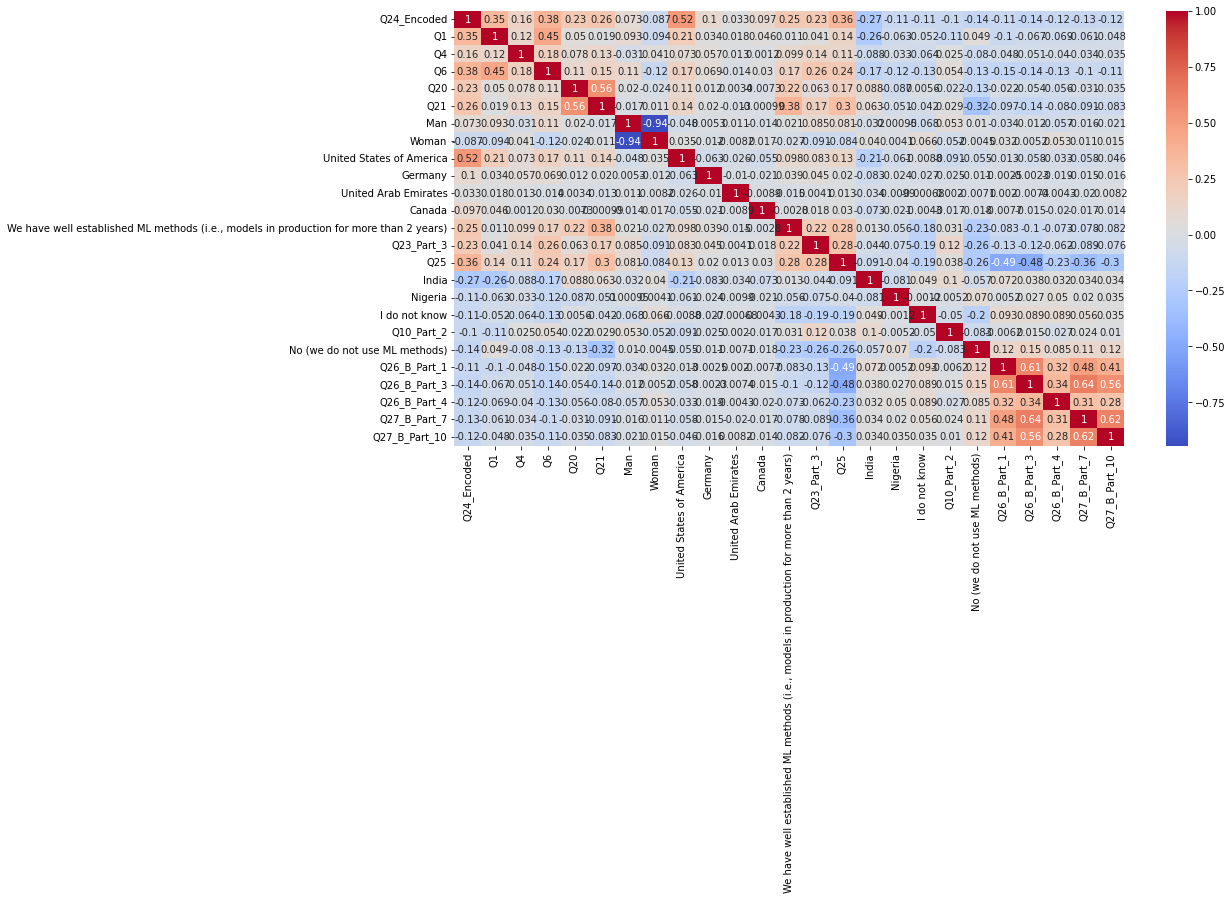

In [ ]:
# Correlation heatmap to see all the features that have high and low relations with Q24_Encoded
plt.figure(figsize=(15,8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')

**FEATURE SELECTION:**

In [ ]:
#Importing the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Spliting the data into x and y
final_df2 = final_df
x = final_df2.drop(columns=['Q24','Q24_buckets','Q24_Encoded'])
y = final_df2['Q24_Encoded']

In [ ]:
# Spliting the dataset into x_train/test and y_train/test with 80%-20% split
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.8, random_state = 0)

In [ ]:
#Standardizing the dataset after spliting to prevent the testing set from getting compromised
col = list(x.columns)
scalar = StandardScaler()
x_train_std = scalar.fit_transform(x_train)
x_train_std = pd.DataFrame(x_train_std, columns=col)
x_test_std = scalar.transform(x_test)
x_test_std = pd.DataFrame(x_test_std, columns=col)

In [ ]:
# To perform feature selection importing the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

In [ ]:
#Performing feature selection using lasso regression and selectfrommodel library
l1_feature_select = SelectFromModel(LogisticRegression(C=0.005,penalty='l1', solver='saga'),threshold=0.00002)
l1_feature_select.fit(x_train_std, y_train)
l1_support = l1_feature_select.get_support()
l1_feature_select = x_train_std.columns[(l1_support)]
print('Selected', len(l1_feature_select), 'featurs')
print('The Selected Features are:', l1_feature_select)

Selected 31 featurs
The Selected Features are: Index(['Q1', 'Q4', 'Q6', 'Q20', 'Q21', 'Man', 'Canada', 'Germany', 'India',
       'Indonesia', 'Iran, Islamic Republic of...', 'Nigeria', 'Pakistan',
       'Spain', 'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'I do not know',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'Q15', 'Q25', 'Q7_Part_4', 'Q7_Part_5', 'Q7_Part_10', 'Q9_Part_10',
       'Q10_Part_10', 'Q12_Part_3', 'Q23_Part_3', 'Q23_Part_6', 'Q35_A_Part_8',
       'Q28_B_Part_10', 'Q35_B_Part_8'],
      dtype='object')


In [ ]:
#These are the final selected features based on the lasso regression and the correlation heatmap
#Didn't end up using these as it gave poor results and therefore went with PCA for feature selection
final_feat_df2 = final_df[['Q1', 'Q4', 'Q6', 'Q20', 'Q21', 'Man', 'Woman', 'Canada', 'Germany',
       'India', 'Indonesia', 'Iran, Islamic Republic of...', 'Kenya','Q10_Part_2',
       'Nigeria', 'Pakistan', 'Spain','No (we do not use ML methods)',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'I do not know','Q27_B_Part_10',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'Q7_Part_4', 'Q7_Part_5', 'Q7_Part_10', 'Q10_Part_13', 'Q12_Part_3',
       'Q15', 'Q23_Part_3', 'Q23_Part_6', 'Q25', 'Q28_A_Part_10',
       'Q28_B_Part_10', 'Q35_B_Part_8']]

These are the final selected features based on the lasso regression and the correlation heatmap. Didn't end up using these as it gave poor results and therefore went with PCA for feature selection. 

In [ ]:
#APPLYING PCA TO THE TRAINING AND TESTING DATA to perform feature selection
pca = PCA(0.95) #RETAINING 95% OF THE VARIANCE
pca.fit(x_train_std) 
pca_x_train = pca.transform(x_train_std)
pca_x_test = pca.transform(x_test_std)

In [ ]:
# To calculate the covariance and eigenvectors to plot the scree plot
df_std = x_train_std
n, m = df_std.shape
#Calculating Covariance and eigenvectors
C = np.dot(df_std.T, df_std) / (n-1) 
eigenValues, eigenVectors = np.linalg.eigh(C) 
#Sorting the eigenvectors based on the eigenvalues
args = (-eigenValues).argsort()
eigenValues = eigenValues[args]
eigenVectors = eigenVectors[:, args]

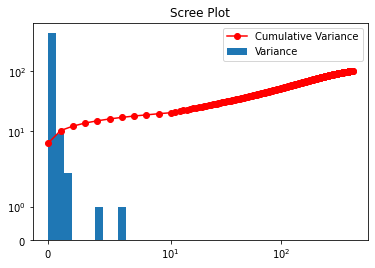

In [ ]:
# Calculating the cumulative variance
eigValSum = sum(eigenValues)
Var = [eigV/eigValSum*100 for eigV in eigenValues]
cumVar = np.cumsum(Var)
#Plotting the scree plot for the dataset to check variance
plt.hist(Var, label='Variance')
plt.plot(cumVar, 'r-o', label='Cumulative Variance')
plt.yscale('symlog',linthreshx = 10.0)
plt.xscale('symlog',linthreshx = 10.0)
plt.title('Scree Plot')
plt.legend()
plt.show()

In [ ]:
print('The number of Features needed to retain 95% of the variance is',pca_x_train.shape[1])

The number of Features needed to retain 95% of the variance is 363


In [ ]:
# Displaying the final selected 363 features after PCA  
final_feat_df = pd.DataFrame(pca_x_train)
final_feat_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362
0,4.344813,-5.163578,3.479801,4.304755,-0.565350,1.920648,2.647441,1.314041,-0.129746,-2.598802,1.105659,-1.057369,-0.923513,-2.333541,-1.442834,-0.763991,0.186321,0.932443,2.240626,-3.156602,-0.480344,-0.255595,2.972167,1.606055,-2.104711,-0.281679,-0.380009,-0.424790,1.385127,0.082763,0.237906,-1.158625,0.119589,0.199272,-0.022058,-0.566008,0.869541,0.095537,1.073840,-0.572187,...,0.295553,0.519931,-0.236098,0.164542,-0.100226,-0.264989,-0.648504,-0.053321,-0.607337,-0.603599,0.290148,0.170701,0.607191,0.078528,-0.221471,-0.005442,0.030744,-0.267139,0.225624,-0.231363,0.374767,-0.480856,0.126785,0.636150,-0.787615,-0.109350,0.238280,0.507559,-0.165264,-0.041059,-0.296898,0.061088,-0.088284,0.429212,-0.273943,-0.447840,0.092133,-0.026891,-0.378205,0.694012
1,-2.803739,0.304928,-2.663170,3.233805,2.507992,-0.683389,0.191050,-1.118570,0.762510,0.191920,0.140570,0.802516,0.874947,-0.398551,0.193531,0.236144,0.708608,2.235754,1.267286,1.625240,-0.242670,3.045703,0.633033,-2.906470,-0.462955,-1.121561,-1.508578,-1.639420,-1.586848,-0.288254,-0.460540,-0.177419,-0.819348,-0.539410,-0.255904,0.516027,-1.823341,-0.868387,-0.045064,0.233424,...,-0.231622,0.441417,-0.241385,-0.493153,0.246570,-0.041640,0.031337,-0.248405,-0.046210,-0.063937,-0.821134,-0.045434,-0.361921,0.831772,-0.046945,0.701530,0.311638,-0.050643,0.860686,1.047202,0.729951,-0.441619,0.415458,-0.073886,-0.546385,-0.263122,-0.386795,-0.049823,-0.327257,0.339965,-0.043142,-0.007114,0.096648,0.359695,-0.314665,0.481981,0.236449,0.738811,-0.389741,0.168566
2,-4.432144,1.442670,0.733121,-4.338780,-0.539074,0.099882,2.149153,-1.032975,0.618217,3.027045,0.043228,-3.370384,-1.094854,-0.111658,-2.047767,0.315159,-0.404305,-1.545057,0.115035,-0.960128,1.358740,-0.511127,2.801867,0.295975,2.135099,0.627596,0.190928,-1.016106,0.115787,-2.249856,-0.833723,-0.097713,-0.823638,0.074942,1.288801,0.446929,-0.934092,-0.544199,-1.552562,0.621645,...,-1.173247,0.319942,0.222084,0.153014,-0.434436,0.065588,0.939935,1.095066,-0.478516,0.492942,-0.202262,-0.648304,0.432270,0.523048,-0.010911,-0.240352,0.483736,0.399518,0.163307,1.220954,-0.587311,-0.271870,0.155079,-0.074674,-0.293303,-0.711431,1.364739,0.919127,0.897559,-1.903265,0.730225,-0.092254,-1.237604,-0.223034,-1.100668,-0.733978,-1.328072,-0.473903,-0.422248,-0.194163
3,7.560965,4.851221,4.698531,-5.394529,2.621124,-2.846676,-0.483847,-3.868750,-1.187240,-2.656655,-1.419320,-0.877686,1.691539,-3.837879,-1.688435,-0.894256,1.330416,-1.507743,-1.150803,-0.185376,-0.392019,1.987442,-4.165504,0.268665,0.031361,-0.055148,1.927376,-0.414588,2.636663,-0.132827,-0.317069,1.406254,-2.229245,0.768805,-4.141131,-2.237028,2.417839,0.969776,0.610703,-1.283179,...,1.447521,-1.403769,-0.137638,-2.123921,0.834407,-0.604586,-0.075596,-1.911411,-2.138318,-0.592905,0.672772,0.108106,0.419510,0.393536,-1.739219,1.904886,1.619131,-0.771820,-2.882085,0.179563,0.014055,-0.381165,-1.980453,-0.527165,0.174423,2.456899,0.325500,-0.379648,1.725355,-0.084427,-1.288847,3.632521,0.818572,0.014554,-2.318852,-2.040691,-1.635160,0.635482,1.153345,0.338729
4,-0.511211,-4.238405,-0.689751,-0.430084,0.291581,0.266189,-2.658120,0.801136,0.239550,0.758386,0.949428,-1.010420,-1.303477,0.356795,-0.758103,-1.714766,3.042593,1.261849,-1.947076,1.617382,0.686758,-0.803440,-0.031187,0.465782,1.651969,-1.553214,-0.877403,-1.251305,-1.074773,0.663458,1.756011,1.281390,1.139987,-0.088085,-0.158904,-0.912831,-1.384955,-0.510921,0.466271,-0.213256,...,-0.722266,-0.622232,-0.022892,0.114248,0.117715,-0.082633,-0.072879,-0.064721,0.209902,-0.343053,-0.332578,0.552004,-0.079747,0.659171,0.078832,-0.486662,0.432878,0.403210,-0.346001,0.050246,0.169957,0.074253,-0.198376,-0.465196,0.130193,0.255887,0.164848,-0.18

**PART 3: Model implementation:**

In [ ]:
#Training and testing set PCA
x_train_pca, x_test_pca,y_train_pca,y_test_pca = train_test_split(pca_x_train,y_train,train_size=0.8,random_state=0) 

#Training and Validation set PCA
x_train_pca1, x_val_pca,y_train_pca1,y_val_pca = train_test_split(x_train_pca,y_train_pca,train_size=0.8,random_state=0) 

In [ ]:
# Standardizing the PCA selected features 
scalarpca = StandardScaler()
std_x_train_pca = scalarpca.fit_transform(x_train_pca1) #training set with 60% data
std_x_val_pca = scalarpca.transform(x_val_pca) #val set with 20%
std_x_test_pca = scalarpca.transform(x_test_pca) #test/holdout set with 20%

# Converting the numpy array into a dataframe
std_x_train_pca = pd.DataFrame(std_x_train_pca)


In [ ]:
# Importing some necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [ ]:
# Function to perform ordinal regression
def ordinal_regression(X,y,c,l):
  kf = KFold(n_splits=10)
  f1_scores_test = [] 
  f1_scores_train = []
  accuracy_scores_test = [] 
  accuracy_scores_train = [] 
  varriance_test = []
  fold = 0
  for train_index, test_index in kf.split(X):
    print("fold:",fold)
    fold += 1
    X_train, X_test = X.values[train_index], X.values[test_index]
    X_train = pd.DataFrame(X_train,columns=X.columns)
    X_test= pd.DataFrame(X_test,columns=X.columns)
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    pred_store= np.zeros((len(X_train),14))
    pred_store_test= np.zeros((len(X_test),14))
    Y_new = Y_train.copy()
    Y_te_new = Y_test.copy()
    # perform binary classification looping through all 15 classes
    for i in range(14):
      #spliting them into class 0 and class 1
        Y_new[Y_train <=i] = 0 
        Y_new[Y_train >i] = 1  
        model = LogisticRegression(C=c,penalty=l,solver='saga')
        model.fit(X_train,Y_new)
        # training set
        predictions_0 = model.predict_proba(X_train)[:,0]
        predictions_1 = model.predict_proba(X_train)[:,1]
        pred_store[:,i] = predictions_0
        # validation set
        predictions_0_test = model.predict_proba(X_test)[:,0]
        predictions_1_test = model.predict_proba(X_test)[:,1]
        pred_store_test[:,i] = predictions_0_test
  #Calculating the probabilities by subtracting it from the previous class for test set
    pred_diff_test = np.diff(pred_store_test)
    pred_diff2_test = np.append(pred_store_test[:,0].reshape(-1,1),pred_diff_test,axis=1)
    pred_values_test = np.append(pred_diff2_test,predictions_1_test.reshape(-1,1),axis=1)
  #Calculating the probabilities by subtracting it from the previous class for train set
    pred_diff = np.diff(pred_store)
    pred_diff2 = np.append(pred_store[:,0].reshape(-1,1),pred_diff,axis=1)
    pred_values = np.append(pred_diff2,predictions_1.reshape(-1,1),axis=1)
    #Training prediction
    y_pred = np.argmax(pred_values, axis=1)
    # Testing prediction
    y_pred_test = np.argmax(pred_values_test, axis=1)
    
    f1_score_train = f1_score(Y_train, y_pred,average = 'weighted')  #f1 train
    accuracy_test = accuracy_score(Y_test,y_pred_test) #accuracy test
    f1score_test = f1_score(Y_test, y_pred_test,average = 'weighted') #test f1
    accuracy_score_train = accuracy_score(Y_train, y_pred) #accuracy train
    f1_scores_train.append(f1_score_train) #append train f1
    f1_scores_test.append(f1score_test) #append test f1
    accuracy_scores_train.append(accuracy_score_train) #append acc train
    accuracy_scores_test.append(accuracy_test) #append acc test

    print("f1_Score Train: {}".format(f1_score_train)) #f1 train print
    print("Training Accuracy Score: {}".format(accuracy_score_train)) #acc train print
    print("f1_Score Test: {}".format(f1score_test)) #f1 score test print
    print("Testing Accuracy Score: {}".format(accuracy_test)) #acc test print    
# Calculating the mean accuracy for training/testing
  mean_accuracy_train = np.mean(accuracy_scores_train)
  mean_accuracy_test = np.mean(accuracy_scores_test)
  #Calculating the variance for testing and training
  acc_variance_test = np.var(accuracy_scores_test)
  acc_variance_train = np.var(accuracy_scores_train)
  varriance_test.append(acc_variance_test)
  #Calculating the f1 score for testing and training  
  max_f1_scores_train = max(f1_scores_train)
  max_f1_scores_test = max(f1_scores_test)
 #Calculating the max accuracy for testing and training
  max_accuracy_test = max(accuracy_scores_test)
  max_accuracy_train = max(accuracy_scores_train)
  print('-----------THE FINAL RESULTS------------')
  print('The max F1 test score is: {0}'.format(max_f1_scores_test))
  print('The max F1 train score is: {0}'.format(max_f1_scores_train))
  print('The testing accuracy variance is: {0}'.format(acc_variance_test))
  print('The mean accuracy for testing set is: {0}'.format(mean_accuracy_test))
  print('The mean accuracy for training set is: {0}'.format(mean_accuracy_train))
  print('The max accuracy for testing set is: {0}'.format(max_accuracy_test))
  print('The max accuracy for training set is: {0}'.format(max_accuracy_train))    
  return pred_values, pred_values_test

In [ ]:
#MODEL 1 WITH L2 PENALTY AND SAGA SOLVER AND C=0.002 
pred_values = ordinal_regression(std_x_train_pca,y_train_pca1,c=0.0002,l='l2')

fold: 0
f1_Score Train: 0.23739058269085253
Training Accuracy Score: 0.40894374747065965
f1_Score Test: 0.24479402497374256
Testing Accuracy Score: 0.4163636363636364
fold: 1
f1_Score Train: 0.2396032578425944
Training Accuracy Score: 0.4111695669769324
f1_Score Test: 0.22501893939393938
Testing Accuracy Score: 0.39636363636363636
fold: 2
f1_Score Train: 0.23952043982402973
Training Accuracy Score: 0.41108638478656684
f1_Score Test: 0.2257227197488381
Testing Accuracy Score: 0.3970856102003643
fold: 3
f1_Score Train: 0.23851412559418403
Training Accuracy Score: 0.4100748533279385
f1_Score Test: 0.23466594939456573
Testing Accuracy Score: 0.40619307832422585
fold: 4
f1_Score Train: 0.24032654015339275
Training Accuracy Score: 0.4118956099534696
f1_Score Test: 0.21865562789009924
Testing Accuracy Score: 0.38979963570127507
fold: 5
f1_Score Train: 0.2367064407830652
Training Accuracy Score: 0.4082540967024074
f1_Score Test: 0.2510629266574776
Testing Accuracy Score: 0.4225865209471767
fol

In [ ]:
# MODEL 1 Output of the probability belong to each salary buckets for l2 penalty and logistic Regression C=0.002 and saga solver

df_prob_val = pd.DataFrame((pred_values[1][0]), columns=['Probability'], 
                       index=['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
                                   '40,000-49,999', '50,000-59,999', '60,000-69,999','70,000-79,999',
                                   '80,000-89,999', '90,000-99,999','100,000-124,999', 
                                   '125,000-149,999', '150,000-199,999', '200,000-249,999',
                                   '>250,000'])
df_prob_val

,Probability
"0-9,999",0.409385
"10,000-19,999",0.113966
"20,000-29,999",0.064042
"30,000-39,999",0.032457
"40,000-49,999",0.065367
"50,000-59,999",0.046946
"60,000-69,999",0.028511
"70,000-79,999",0.036212
"80,000-89,999",0.024721
"90,000-99,999",0.032254


In [ ]:
#MODEL 2 WITH L1 PENALTY AND SAGA SOLVER AND C=0.005
pred_values = ordinal_regression(std_x_train_pca,y_train_pca1,c=0.005,l='l1')

fold: 0
f1_Score Train: 0.24508717855881046
Training Accuracy Score: 0.41137191420477537
f1_Score Test: 0.2592255017709563
Testing Accuracy Score: 0.42363636363636364
fold: 1
f1_Score Train: 0.24686737879559964
Training Accuracy Score: 0.4133953864832052
f1_Score Test: 0.2303251893225508
Testing Accuracy Score: 0.3981818181818182
fold: 2
f1_Score Train: 0.24867898769671898
Training Accuracy Score: 0.4145255917459033
f1_Score Test: 0.23281918287230813
Testing Accuracy Score: 0.3989071038251366
fold: 3
f1_Score Train: 0.2467659872151636
Training Accuracy Score: 0.4129071414120979
f1_Score Test: 0.2403476887793397
Testing Accuracy Score: 0.4080145719489982
fold: 4
f1_Score Train: 0.24535911750993078
Training Accuracy Score: 0.4131094477038236
f1_Score Test: 0.22954478161454092
Testing Accuracy Score: 0.39344262295081966
fold: 5
f1_Score Train: 0.24463030517007794
Training Accuracy Score: 0.4106817722031155
f1_Score Test: 0.25717939215206975
Testing Accuracy Score: 0.424408014571949
fold: 

In [ ]:
# MODEL 2 Output of the probability belong to each salary buckets for l1 penalty and logistic Regression C=0.005 and saga solver

df_prob_val = pd.DataFrame((pred_values[1][0]), columns=['Probability'], 
                       index=['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
                                   '40,000-49,999', '50,000-59,999', '60,000-69,999','70,000-79,999',
                                   '80,000-89,999', '90,000-99,999','100,000-124,999', 
                                   '125,000-149,999', '150,000-199,999', '200,000-249,999',
                                   '>250,000'])
df_prob_val

,Probability
"0-9,999",0.319853
"10,000-19,999",0.051704
"20,000-29,999",0.070726
"30,000-39,999",0.042704
"40,000-49,999",0.044218
"50,000-59,999",0.080010
"60,000-69,999",0.062896
"70,000-79,999",0.066945
"80,000-89,999",0.040244
"90,000-99,999",0.054294


In [ ]:
#MODEL 3 WITH none PENALTY AND SAGA SOLVER AND C=0.05
pred_values = ordinal_regression(std_x_train_pca,y_train_pca1,c=0.05,l='none')

fold: 0
f1_Score Train: 0.5391406606898033
Training Accuracy Score: 0.5694050991501416
f1_Score Test: 0.38800037107151425
Testing Accuracy Score: 0.43454545454545457
fold: 1
f1_Score Train: 0.5414101016214122
Training Accuracy Score: 0.5722379603399433
f1_Score Test: 0.3703788748279167
Testing Accuracy Score: 0.4090909090909091
fold: 2
f1_Score Train: 0.5345129388575747
Training Accuracy Score: 0.5650414727898038
f1_Score Test: 0.36784328041517206
Testing Accuracy Score: 0.4207650273224044
fold: 3
f1_Score Train: 0.5482733017932827
Training Accuracy Score: 0.5775844628767954
f1_Score Test: 0.36286451763092814
Testing Accuracy Score: 0.4080145719489982
fold: 4
f1_Score Train: 0.5443739852325624
Training Accuracy Score: 0.5747521747926361
f1_Score Test: 0.3639478521319541
Testing Accuracy Score: 0.40619307832422585
fold: 5
f1_Score Train: 0.5426506413901357
Training Accuracy Score: 0.5719198867084766
f1_Score Test: 0.3718374072015919
Testing Accuracy Score: 0.41530054644808745
fold: 6
f1

In [ ]:
# MODEL 3 Output of the probability belong to each salary buckets for none penalty and logistic Regression C=0.05 and saga solver
df_prob_val = pd.DataFrame((pred_values[1][4]), columns=['Probability'], 
                       index=['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
                                   '40,000-49,999', '50,000-59,999', '60,000-69,999','70,000-79,999',
                                   '80,000-89,999', '90,000-99,999','100,000-124,999', 
                                   '125,000-149,999', '150,000-199,999', '200,000-249,999',
                                   '>250,000'])
df_prob_val

,Probability
"0-9,999",0.017703
"10,000-19,999",0.001254
"20,000-29,999",-0.010505
"30,000-39,999",0.001125
"40,000-49,999",0.007050
"50,000-59,999",0.005916
"60,000-69,999",0.006819
"70,000-79,999",0.064721
"80,000-89,999",0.092671
"90,000-99,999",0.037989


Bias is the difference between the prediction of the model and the real test value. A model with high bias always oversimplifies, leading to underfitting and high error on both training and testing data.
Variance is the variability of model prediction for a given data point or a value that tells us the spread of our data. A model with high variance will not generalize on the new/unknown dataset; it is also called overfitting, memorizing the training data. As a result, such models perform very well on training data but do poorly on the testing set.
The trade-off in complexity means there is a trade-off between bias and variance; the algorithm cannot be more complex and less complex at the same time. An optimal model performs reasonably well on both the training and testing set.
The 3 models that we have run here the **best is model 3**, as it has a training accuracy of 57% and testing accuracy of 44%, whereas the other two models have the accuracy of testing set greater than the training set. It is usual for the training set to have slightly higher accuracy than the test set.

**PART 4 Model Tuning:**

**Hyperparameter Tuning:** 

The two most important hyperparameters that we are going to tune are the c value and the penalty. The c-value in logistic regression indicates the inverse of regularization strength, and the penalty is l1,l2, and none. These two were chosen based on the results from part 3 model implementation were; changing these two values gave very different and drastic changes to the results. So, to select the correct value and the penalty, we use the grid search method, i.e., we cycle through all possible combinations using these parameters and choose the one that gives the best results.  

In [ ]:
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [ ]:
# For hyperparameter tuning two important parameters are selected the c-value and penalty and we are doing a grid search method to find the optimum parameters
def gridsearch_ordinal(X,y):
  kf = KFold(n_splits=10)
  f1_scores_test = [] 
  f1_scores_train = []
  accuracy_scores_test = [] 
  accuracy_scores_train = [] 
  varriance_test = []
  recall_scores_train = []
  recall_scores_test = []
  pre_scores_train = []
  pre_scores_test = []
  fold = 0
  fold_num = []
  c_values = np.logspace(-4,4,7)
  penalties = ['l1','none','l2']

  for c in c_values:
    for l in penalties:
      for train_index, test_index in kf.split(X):
        print("fold:",fold)
        print('The c value is:',c)
        print('The penalty is:',l)
        fold_num.append(fold)
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test= pd.DataFrame(X_test,columns=X.columns)
        Y_train, Y_test = y.values[train_index], y.values[test_index]
        pred_store= np.zeros((len(X_train),14))
        pred_store_test= np.zeros((len(X_test),14))
        Y_new = Y_train.copy()
        Y_te_new = Y_test.copy()
      # perform binary classification looping through all 15 classes
        for i in range(14):
      #spliting them into class 0 and class 1
            Y_new[Y_train <=i] = 0
            Y_new[Y_train >i] = 1
            model = LogisticRegression(C=c,penalty=l,solver='saga')
            model.fit(X_train,Y_new)
            # training set
            predictions_0 = model.predict_proba(X_train)[:,0]
            predictions_1 = model.predict_proba(X_train)[:,1]
            pred_store[:,i] = predictions_0
            # testing set
            predictions_0_test = model.predict_proba(X_test)[:,0]
            predictions_1_test = model.predict_proba(X_test)[:,1]
            pred_store_test[:,i] = predictions_0_test
  #Calculating the probabilities by subtracting it from the previous class for test set
        pred_diff_test = np.diff(pred_store_test)
        pred_diff2_test = np.append(pred_store_test[:,0].reshape(-1,1),pred_diff_test,axis=1)
        pred_values_test = np.append(pred_diff2_test,predictions_1_test.reshape(-1,1),axis=1)
  #Calculating the probabilities by subtracting it from the previous class for train set
        pred_diff = np.diff(pred_store)
        pred_diff2 = np.append(pred_store[:,0].reshape(-1,1),pred_diff,axis=1)
        pred_values = np.append(pred_diff2,predictions_1.reshape(-1,1),axis=1)
        #Training prediction
        y_pred = np.argmax(pred_values, axis=1)
        #Testing prediction
        y_pred_test = np.argmax(pred_values_test, axis=1)
        
    # Calculating all the scoring metrics F1, Precision,Recall and Accuracy
        f1_score_train = f1_score(Y_train, y_pred,average = 'weighted') 
       
        pre_score_train = precision_score(Y_train, y_pred,average = 'weighted') 
        recall_score_train = recall_score(Y_train, y_pred,average = 'weighted') 
       
        pre_score_test = precision_score(Y_test, y_pred_test,average = 'weighted') 
        recall_score_test = recall_score(Y_test, y_pred_test,average = 'weighted')  
       
        accuracy_test = accuracy_score(Y_test,y_pred_test)
        f1score_test = f1_score(Y_test, y_pred_test,average = 'weighted') 
        accuracy_score_train = accuracy_score(Y_train, y_pred) 
        f1_scores_train.append(f1_score_train) 
        f1_scores_test.append(f1score_test) 
        accuracy_scores_train.append(accuracy_score_train) 
        accuracy_scores_test.append(accuracy_test) 
        recall_scores_test.append(recall_score_test)
        recall_scores_train.append(recall_score_train)
        pre_scores_test.append(pre_score_test)
        pre_scores_train.append(pre_score_train)


        print("f1_Score Train: {}".format(f1_score_train)) 
        print("Training Accuracy Score: {}".format(accuracy_score_train)) 
        print("f1_Score Test: {}".format(f1score_test)) 
        print("Testing Accuracy Score: {}".format(accuracy_test)) 
        print('The Training Precision score: {}'.format(pre_score_train))    
        print('The Testing Precision score: {}'.format(pre_score_test)) 
        print('The Training Recall score: {}'.format(recall_score_train)) 
        print('The Testing Recall score: {}'.format(recall_score_test)) 
      mean_accuracy_train = np.mean(accuracy_scores_train)
      mean_accuracy_test = np.mean(accuracy_scores_test)
      
      acc_variance_test = np.var(accuracy_scores_test)
      acc_variance_train = np.var(accuracy_scores_train)
      varriance_test.append(acc_variance_test)
      
      max_f1_scores_train = max(f1_scores_train)
      max_f1_scores_test = max(f1_scores_test)
      
      max_accuracy_test = max(accuracy_scores_test)
      max_accuracy_train = max(accuracy_scores_train)

      max_pre_score_test = max(pre_scores_test)
      max_pre_score_train = max(pre_scores_train)
      max_recall_score_test = max(recall_scores_test)
      max_recall_score_train = max(recall_scores_train)



  print('-----------THE FINAL RESULTS------------')
  print('The max F1 test score is: {0}'.format(max_f1_scores_test))
  print('The max F1 train score is: {0}'.format(max_f1_scores_train))
  print('The testing accuracy variance is: {0}'.format(acc_variance_test))
  print('The mean accuracy for testing set is: {0}'.format(mean_accuracy_test))
  print('The mean accuracy for training set is: {0}'.format(mean_accuracy_train))
  print('The max accuracy for testing set is: {0}'.format(max_accuracy_test))
  print('The max accuracy for training set is: {0}'.format(max_accuracy_train))
  print('The max Training Precision score: {}'.format(max_pre_score_train))    
  print('The max Testing Precision score: {}'.format(max_pre_score_test)) 
  print('The max Training Recall score: {}'.format(max_recall_score_train)) 
  print('The max Testing Recall score: {}'.format(max_recall_score_test))     
  return pred_values_test, f1_scores_train, f1_scores_test, accuracy_scores_train, accuracy_scores_test, fold_num, recall_scores_test,pre_scores_test

In [ ]:
# Performinig the grid search to find the best hyperparameters
grid_search = gridsearch_ordinal(std_x_train_pca,y_train_pca1)

fold: 0
The c value is: 0.0001
The penalty is: l1
f1_Score Train: 0.23739058269085253
Training Accuracy Score: 0.40894374747065965
f1_Score Test: 0.24479402497374256
Testing Accuracy Score: 0.4163636363636364
The Training Precision score: 0.16723498859534666
The Testing Precision score: 0.1733586776859504
The Training Recall score: 0.40894374747065965
The Testing Recall score: 0.4163636363636364
fold: 1
The c value is: 0.0001
The penalty is: l1
f1_Score Train: 0.2396032578425944
Training Accuracy Score: 0.4111695669769324
f1_Score Test: 0.22501893939393938
Testing Accuracy Score: 0.39636363636363636
The Training Precision score: 0.1690604128079981
The Testing Precision score: 0.15710413223140496
The Training Recall score: 0.4111695669769324
The Testing Recall score: 0.39636363636363636
fold: 2
The c value is: 0.0001
The penalty is: l1
f1_Score Train: 0.23952043982402973
Training Accuracy Score: 0.41108638478656684
f1_Score Test: 0.2257227197488381
Testing Accuracy Score: 0.397085610200

In [ ]:
# Assigning the return values
f1_scores_train =  grid_search[1]  
f1_scores_test = grid_search[2]
accuracy_scores_train = grid_search[3]
accuracy_scores_test = grid_search[4]
fold_num = grid_search[5]
recall_scores_test = grid_search[6]
pre_scores_test = grid_search[7]

In [ ]:
#Based on the F1 score the best model hyperparameters are chosen 
print('The best hyperparameter is from fold:', fold_num[f1_scores_test.index(max(f1_scores_test))])
print('The hyperparameters are c_value: 0.0001 and the penalty is none')
print('The Best Testing Accuracy Score is', max(accuracy_scores_test) ,'and the respective Testing F1 Score is',max(f1_scores_test))
print('The Best Training Accuracy Score is', max(accuracy_scores_train) ,'and the respective Training F1 Score is',max(f1_scores_train))
print('The Best Testing Precision Score is', max(pre_scores_test) ,'and the respective Testing Recall Score is',max(recall_scores_test))


The best hyperparameter is from fold: 18
The hyperparameters are c_value: 0.0001 and the penalty is none
The Best Testing Accuracy Score is 0.4663023679417122 and the respective Testing F1 Score is 0.39502492899778235
The Best Training Accuracy Score is 0.5794052195023265 and the respective Training F1 Score is 0.5550000808176244
The Best Testing Precision Score is 0.37779636232212416 and the respective Testing Recall Score is 0.4663023679417122


**MODEL SELECTION:**

Performance metrics: 

Accuracy: It is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations

Precision: It is the ratio of correctly predicted positive observations to the total predicted positive observations.

Recall: It is the ratio of correctly predicted positive observations to the all observations in actual class

F1 Score: It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. In this case F1 is usually more useful than accuracy, as this dataset has an uneven class distribution.
Hence F1 Score was the primary metric used to select the hyperparameters.

In [ ]:
# Runnimg the best model with the chosen hyperparameters
best_model = ordinal_regression(std_x_train_pca,y_train_pca1,c=0.0001,l='none')

fold: 0
f1_Score Train: 0.5468451145043682
Training Accuracy Score: 0.5728450020234723
f1_Score Test: 0.37634225620695344
Testing Accuracy Score: 0.41818181818181815
fold: 1
f1_Score Train: 0.5517934057065218
Training Accuracy Score: 0.5785107244030757
f1_Score Test: 0.3757363747334336
Testing Accuracy Score: 0.4072727272727273
fold: 2
f1_Score Train: 0.5425363206006022
Training Accuracy Score: 0.5698968237912199
f1_Score Test: 0.36660124692120427
Testing Accuracy Score: 0.41530054644808745
fold: 3
f1_Score Train: 0.5537766941766326
Training Accuracy Score: 0.5794052195023265
f1_Score Test: 0.3733973883636265
Testing Accuracy Score: 0.4080145719489982
fold: 4
f1_Score Train: 0.5500261180032852
Training Accuracy Score: 0.5763706251264414
f1_Score Test: 0.36064825918700427
Testing Accuracy Score: 0.3989071038251366
fold: 5
f1_Score Train: 0.5520768371414989
Training Accuracy Score: 0.5767752377098928
f1_Score Test: 0.36372146156328716
Testing Accuracy Score: 0.3970856102003643
fold: 6
f1

**PART 5 Testing & Discussion:**


In [ ]:
# Function to run the testing set using the best hyperparameters 
def ordinal_regression_testing(X_train,X_test,Y_train,Y_test,c,l):

  pred_store_train= np.zeros((len(X_train),14))
  pred_store_test= np.zeros((len(X_test),14))

  Y_train_new = Y_train.copy()
  Y_test_new = Y_test.copy()
# For loop run 15 times to go through all the classes
  for i in range(14):
    # spliting the data in order to do binary classification
    Y_train_new[Y_train <=i] = 0  #class 0
    Y_train_new[Y_train >i] = 1    #class 1
    model = LogisticRegression(C=c,penalty=l,solver='saga')
    model.fit(X_train,Y_train_new)

    # Training set
    predictions_0_train = model.predict_proba(X_train)[:,0]
    predictions_1_train = model.predict_proba(X_train)[:,1]
    pred_store_train[:,i] = predictions_0_train

    # Testing set
    predictions_0 = model.predict_proba(X_test)[:,0]
    predictions_1 = model.predict_proba(X_test)[:,1]
    pred_store_test[:,i] = predictions_0
  
  #Calculating the probability values by finding the difference between the classes for testing data
  pred_diff = np.diff(pred_store_test)
  pred_diff2 = np.append(pred_store_test[:,0].reshape(-1,1),pred_diff,axis=1)
  pred_values_test = np.append(pred_diff2,predictions_1.reshape(-1,1),axis=1)
  
  #Calculating the probability values by finding the difference between the classes for training data  
  pred_diff_train = np.diff(pred_store_train)
  pred_diff2_train = np.append(pred_store_train[:,0].reshape(-1,1),pred_diff_train,axis=1)
  pred_values_train = np.append(pred_diff2_train,predictions_1_train.reshape(-1,1),axis=1)

  y_pred_train = np.argmax(pred_values_train, axis=1)
  y_pred_test = np.argmax(pred_values_test, axis=1)
  # Calculating F1 score
  f1_score_test = f1_score(Y_test, y_pred_test,average ='weighted') 
  # Calculating accuracy for training and testing sets
  accuracy_train = accuracy_score(Y_train,y_pred_train)
  accuracy_test = accuracy_score(Y_test,y_pred_test)
  # Calculating precision and recall for testing set
  precision_test = precision_score(Y_test,y_pred_test,average ='weighted')
  recall_test = recall_score(Y_test,y_pred_test,average ='weighted')

  print('--------Result-----------')
  print('Training Accuracy:',accuracy_train)
  print('Test Accuracy:',accuracy_test)
  print('Testing F1 Score:',f1_score_test) 
  print('Testing Precision Score:',precision_test) 
  print('Testing Recall Score:',recall_test) 
  
  return Y_train, y_pred_train, Y_test, y_pred_test

In [ ]:
# Testing the model using the holdout/testing set and using the best hyperparameters
testing = ordinal_regression_testing(std_x_train_pca,std_x_test_pca,y_train_pca1,y_test_pca,c=0.0001,l='none')

--------Result-----------
Training Accuracy: 0.5668244719592134
Test Accuracy: 0.43098427489807806
Testing F1 Score: 0.38613749298641054
Testing Precision Score: 0.3591560921119241
Testing Recall Score: 0.43098427489807806


In [ ]:
# Assigning the return values
train_actual = testing[0]
test_actual = testing[2]
train_pred = testing[1]
test_pred = testing[3]

In [ ]:
# For plotting the x_axis for the graph
x_axis = ['0-9,999', '10,000-19,999', '20,000-29,999','30,000-39,999','40,000-49,999',
                    '50,000-59,999','60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999',
                    '100,000-124,999','125,000-149,999','150,000-199,999','200,000-249,999','>250,000']
xpos = np.arange(len(x_axis))


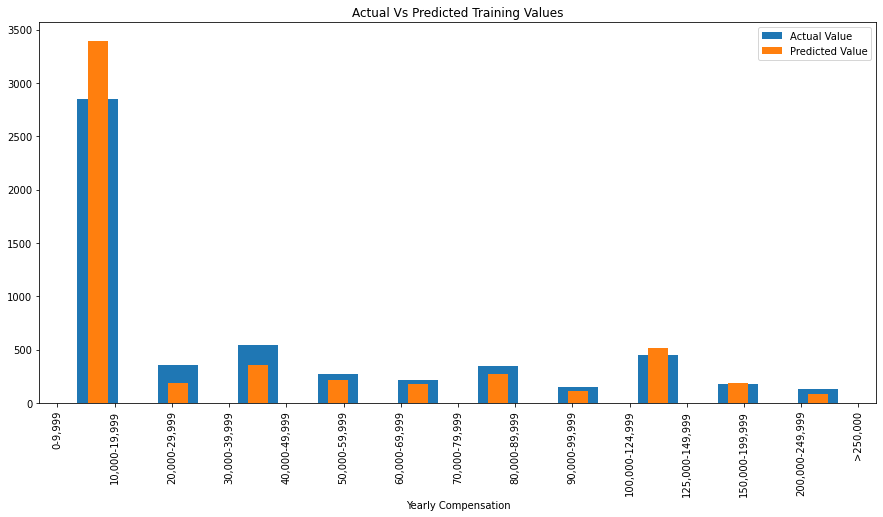

In [ ]:
# Plotting the Actual and predicted training values
plt.figure(figsize=(15,7))
plt.hist(train_actual,label='Actual Value',rwidth=0.5,stacked='step')
plt.hist(train_pred,label='Predicted Value',rwidth=0.25,stacked='step')
plt.xticks(xpos,x_axis)
plt.xticks(rotation=90)
plt.title('Actual Vs Predicted Training Values')
plt.xlabel('Yearly Compensation')
plt.legend()
plt.show()

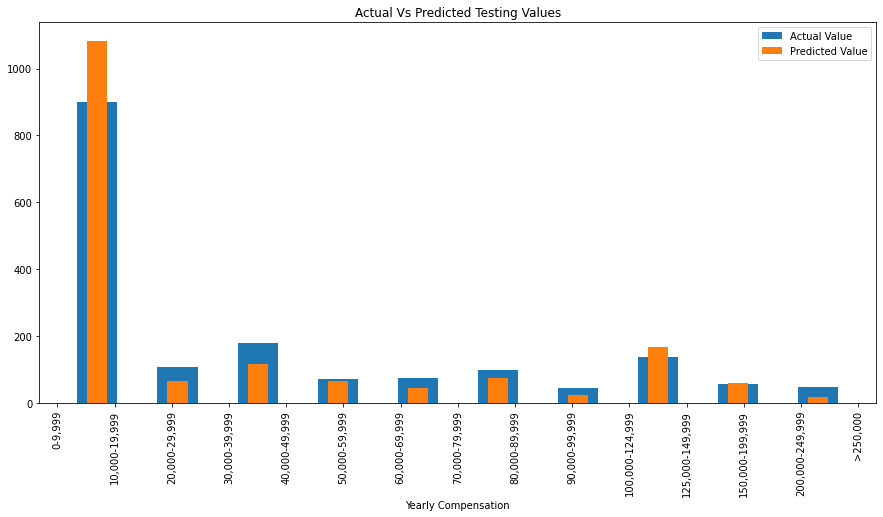

In [ ]:
# Plotting the Actual and predicted Testing Values
plt.figure(figsize=(15,7))
plt.hist(test_actual,label='Actual Value',rwidth=0.5,stacked='step')
plt.hist(test_pred,label='Predicted Value',rwidth=0.25,stacked='step')
plt.xticks(xpos,x_axis)
plt.xticks(rotation=90)
plt.title('Actual Vs Predicted Testing Values')
plt.xlabel('Yearly Compensation')
plt.legend()
plt.show()

**RESULT:**

For the best model, the training accuracy is 56.6%, and the testing accuracy is 43%. The training/testing actual and predicted values have been plotted, and it can be seen that the model did not do well, as the data is unbalanced, most panticipants earn the salary between 0 to 20,000 USD, so it can be seen from the graph that the model is predicting more in that range, resulting in low accuracy.
As the model was fine-tuned using grid search to obtain the hyperparameters, fine-tuning the hyperparameters would not improve the model. The model is also not overfitted as the training accuracy is not high, so the most likely scenario is that the model is underfitted, i.e., the bias is high, and its variance is low; therefore, the model cannot capture the curve properly and also the model cannot generalize well on the unknown dataset as well as a result both the training and testing accuracies are bad. To fix this, we should get more training data, which would lower bias and increase the variance, so that the model would end up fitting well with the test and training set. 
Another way to improve the prediction is by using other ML algorithms/models and seeing how they compare to the ordinal regression we used.